In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('tableau-colorblind10')

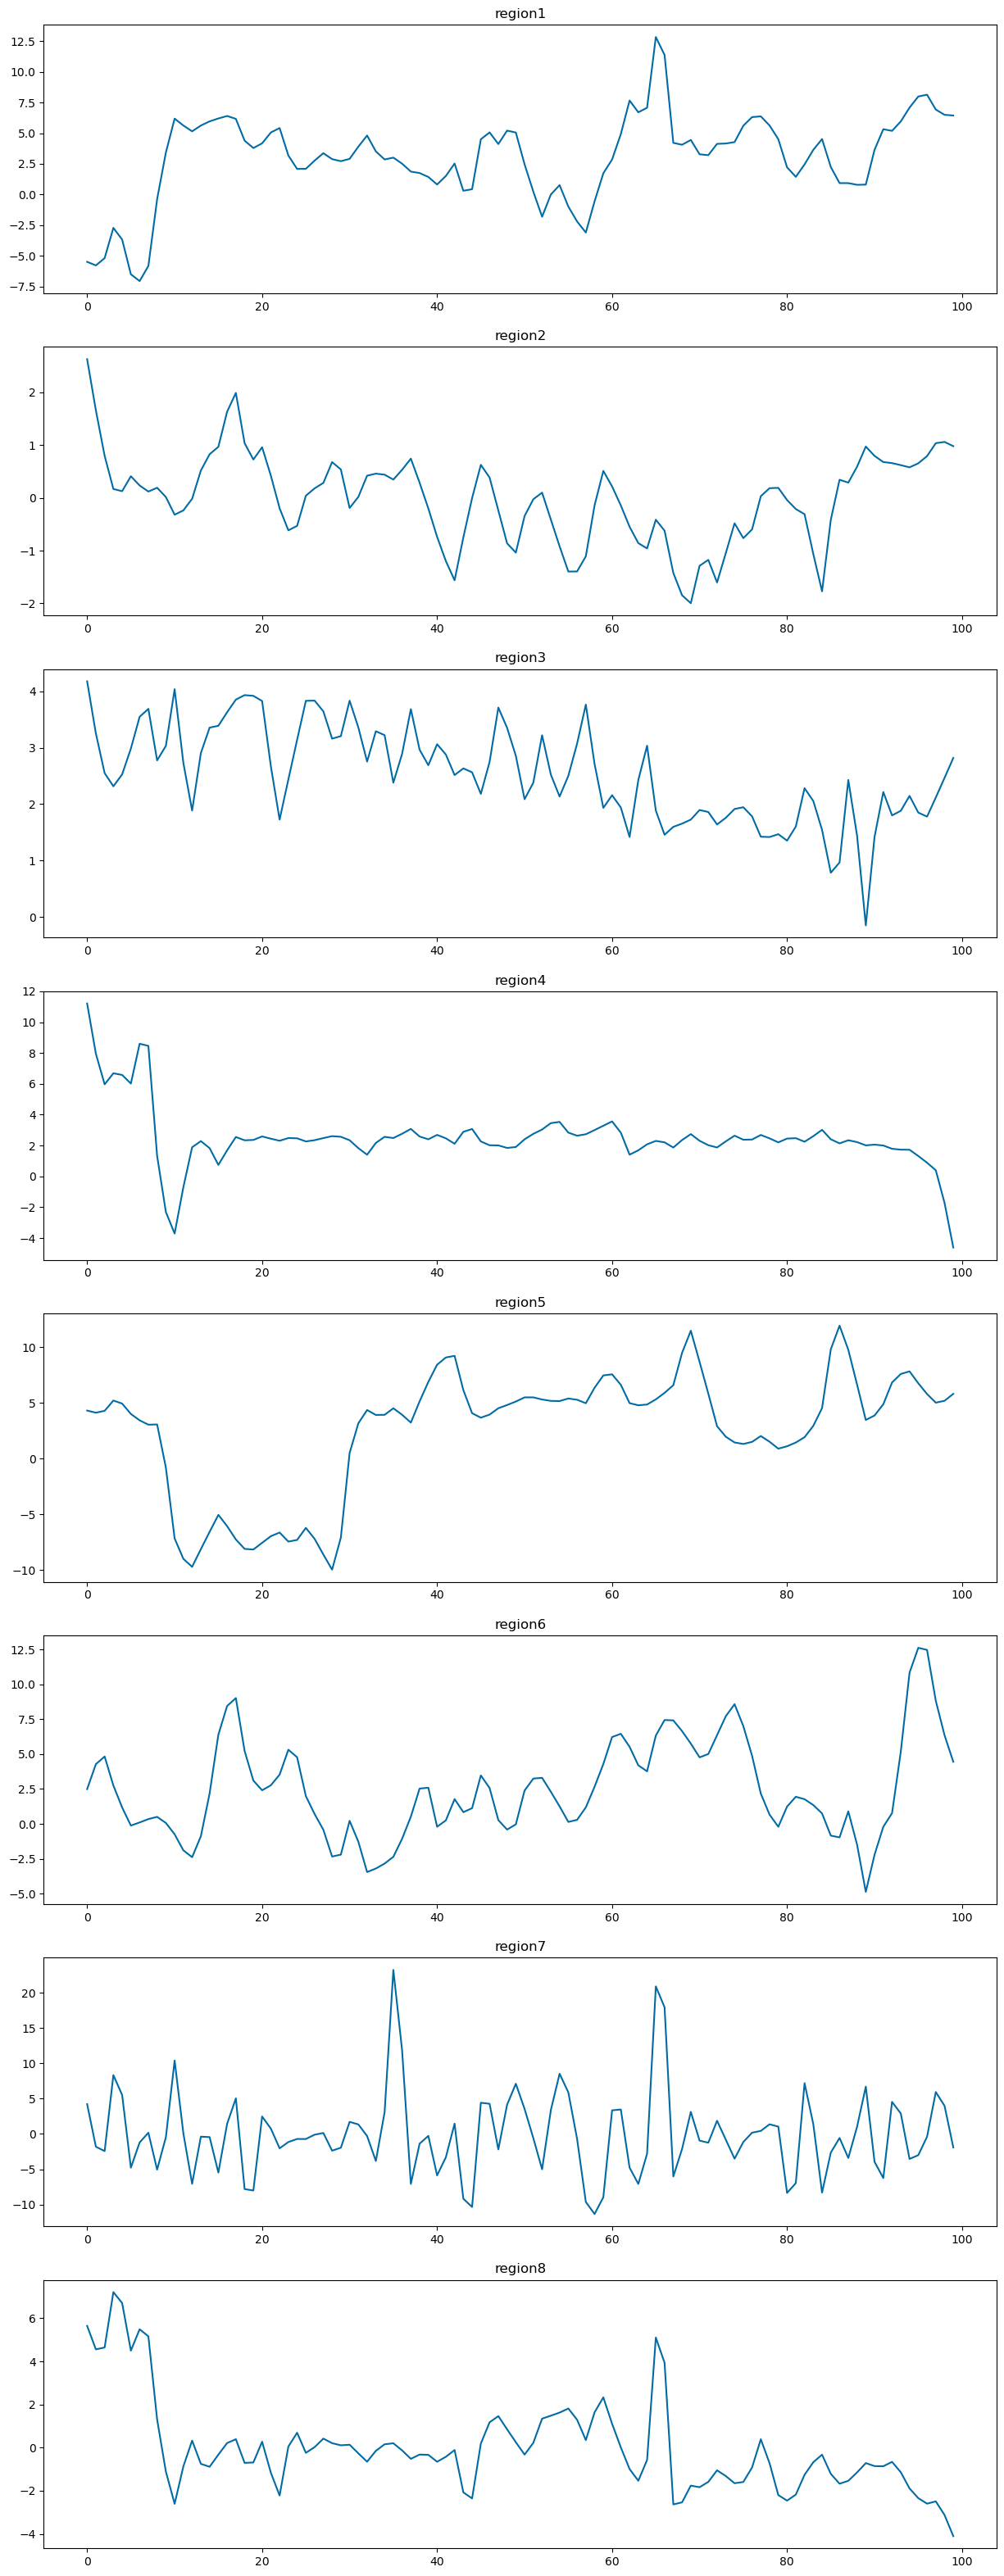

In [3]:
data = pd.read_excel('数据文件.xls')

# 数据分布
fig = plt.figure(figsize=(15, 40))
for i in range(1, 9):
    ax = fig.add_subplot(8, 1, i)
    ax.plot(data.iloc[:, i])
    ax.set_title('region%d' % i)

In [9]:
for i in range(1, 9):
    ts = data.iloc[:, i]

    # 使用adfuller函数进行ADF检验
    result = adfuller(ts)

    # 检验结果
    print('-'*25 + 'region%d' % i + '-'*25)
    print('-'*10 + '0阶差分' + '-'*10)
    print('ADF统计量：', result[0])
    print('p-value：', result[1])
    print('临界值：', result[4])
    print('-'*10 + '1阶差分' + '-'*10)
    ts = ts.diff().dropna()
    result = adfuller(ts)
    print('ADF统计量：', result[0])
    print('p-value：', result[1])
    print('临界值：', result[4])
    print('-'*58 + '\n')

-------------------------region1-------------------------
----------0阶差分----------
ADF统计量： -4.34633529064373
p-value： 0.0003689270924460121
临界值： {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}
----------1阶差分----------
ADF统计量： -5.568500850085114
p-value： 1.4858184025410034e-06
临界值： {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}
----------------------------------------------------------

-------------------------region2-------------------------
----------0阶差分----------
ADF统计量： -1.0620376343071636
p-value： 0.7299710976208247
临界值： {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}
----------1阶差分----------
ADF统计量： -4.153298197516031
p-value： 0.0007896651567454311
临界值： {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}
----------------------------------------------------------

-------------------------region3-------------------------
----------0阶差分----------
ADF统计

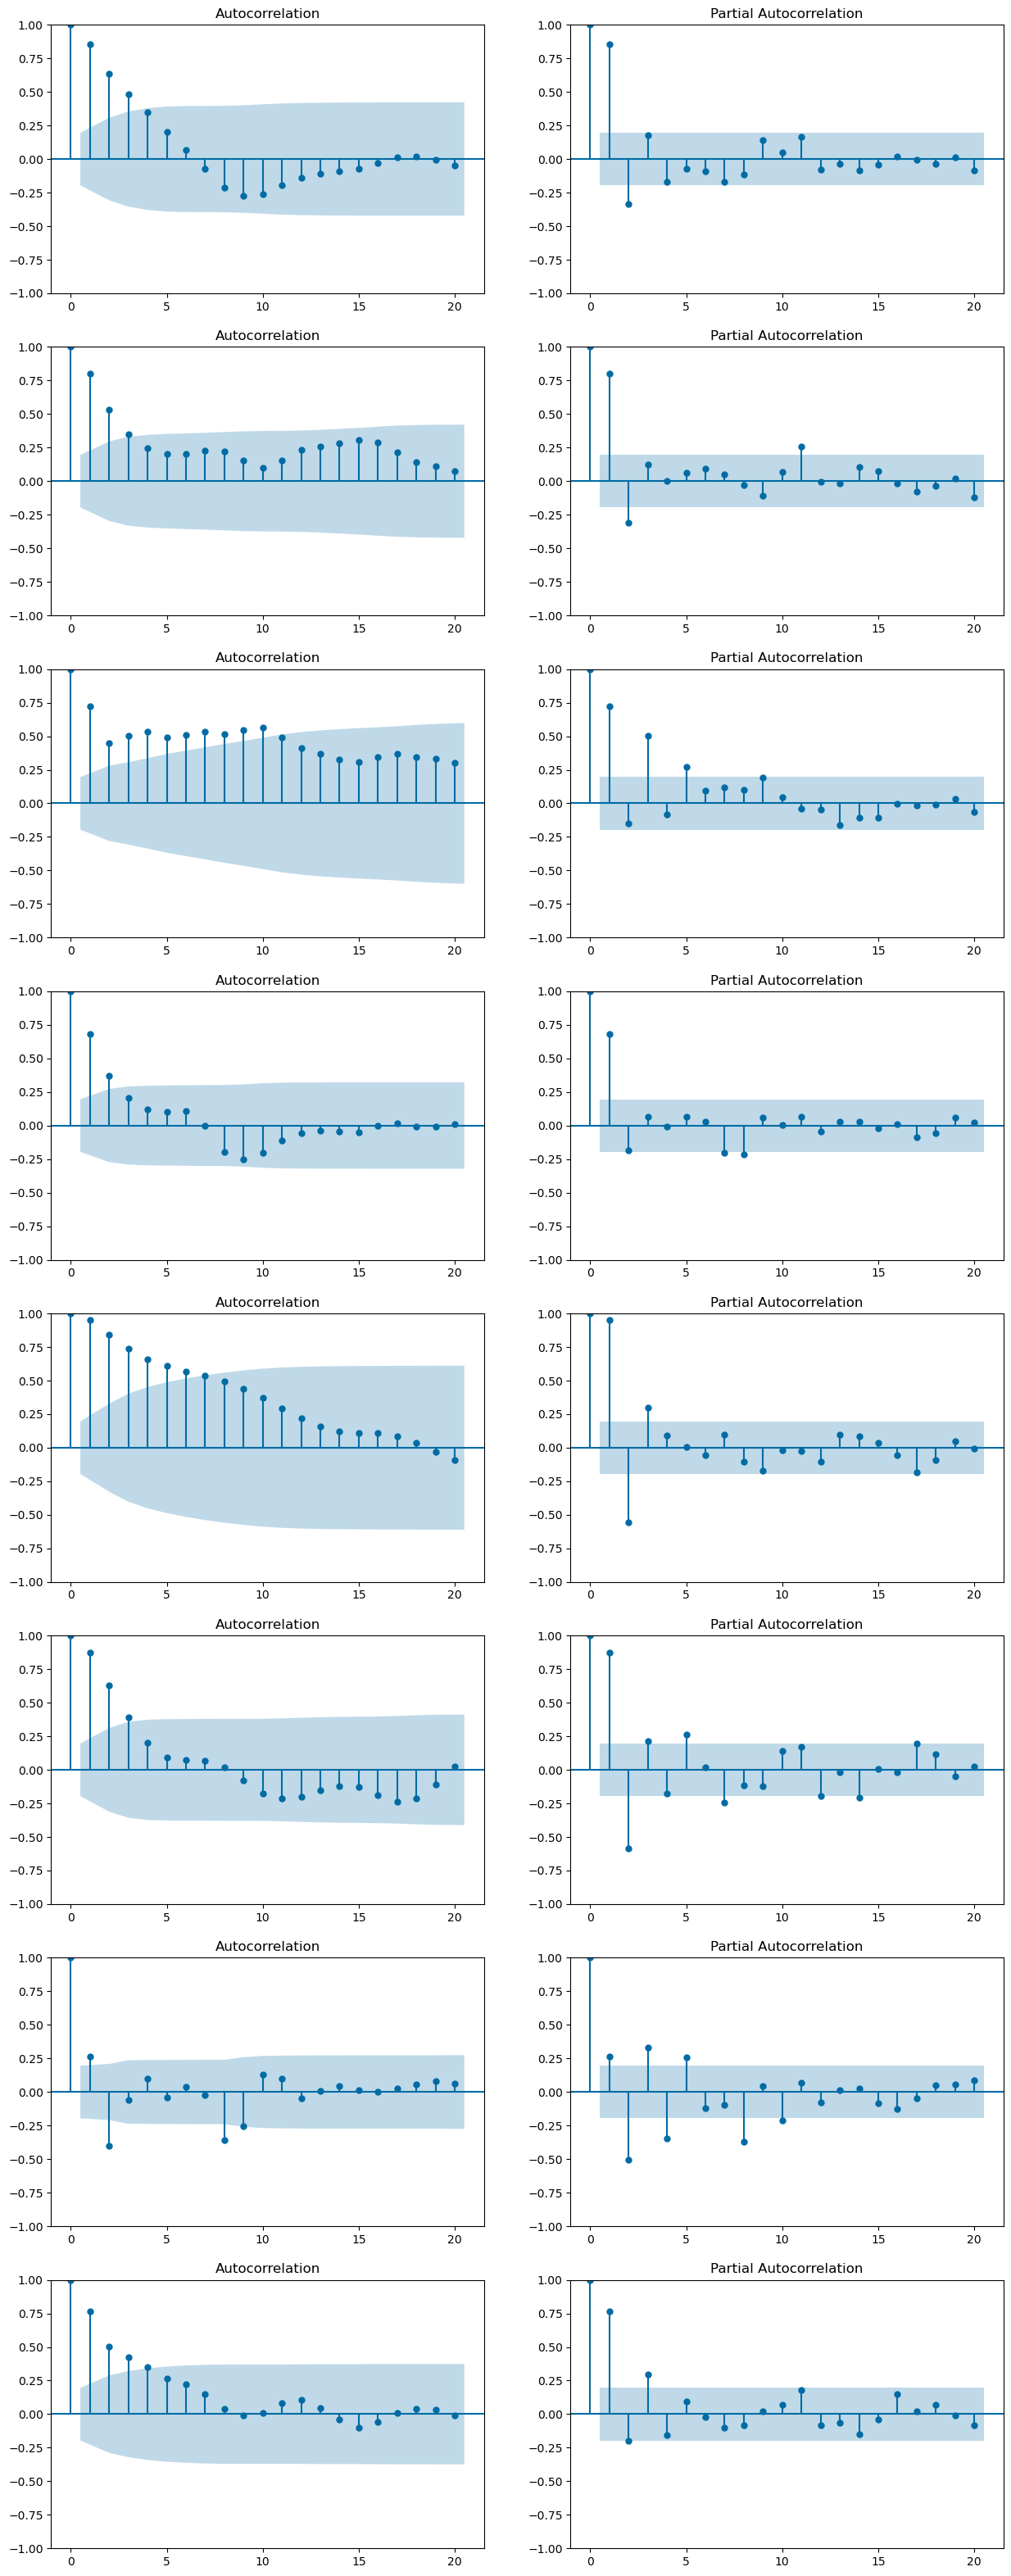

In [11]:
fig = plt.figure(figsize=(15, 40))
for i in range(1, 9):
    # 绘制时间序列的ACF和PACF图
    # 图表每一行代表一个地区
    ts = data.iloc[:, i]
    ax1 = fig.add_subplot(8, 2, 2*i - 1)
    ax2 = fig.add_subplot(8, 2, 2*i)
    plot_acf(ts, ax=ax1)
    plot_pacf(ts, ax=ax2, method='ywm')

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoreg

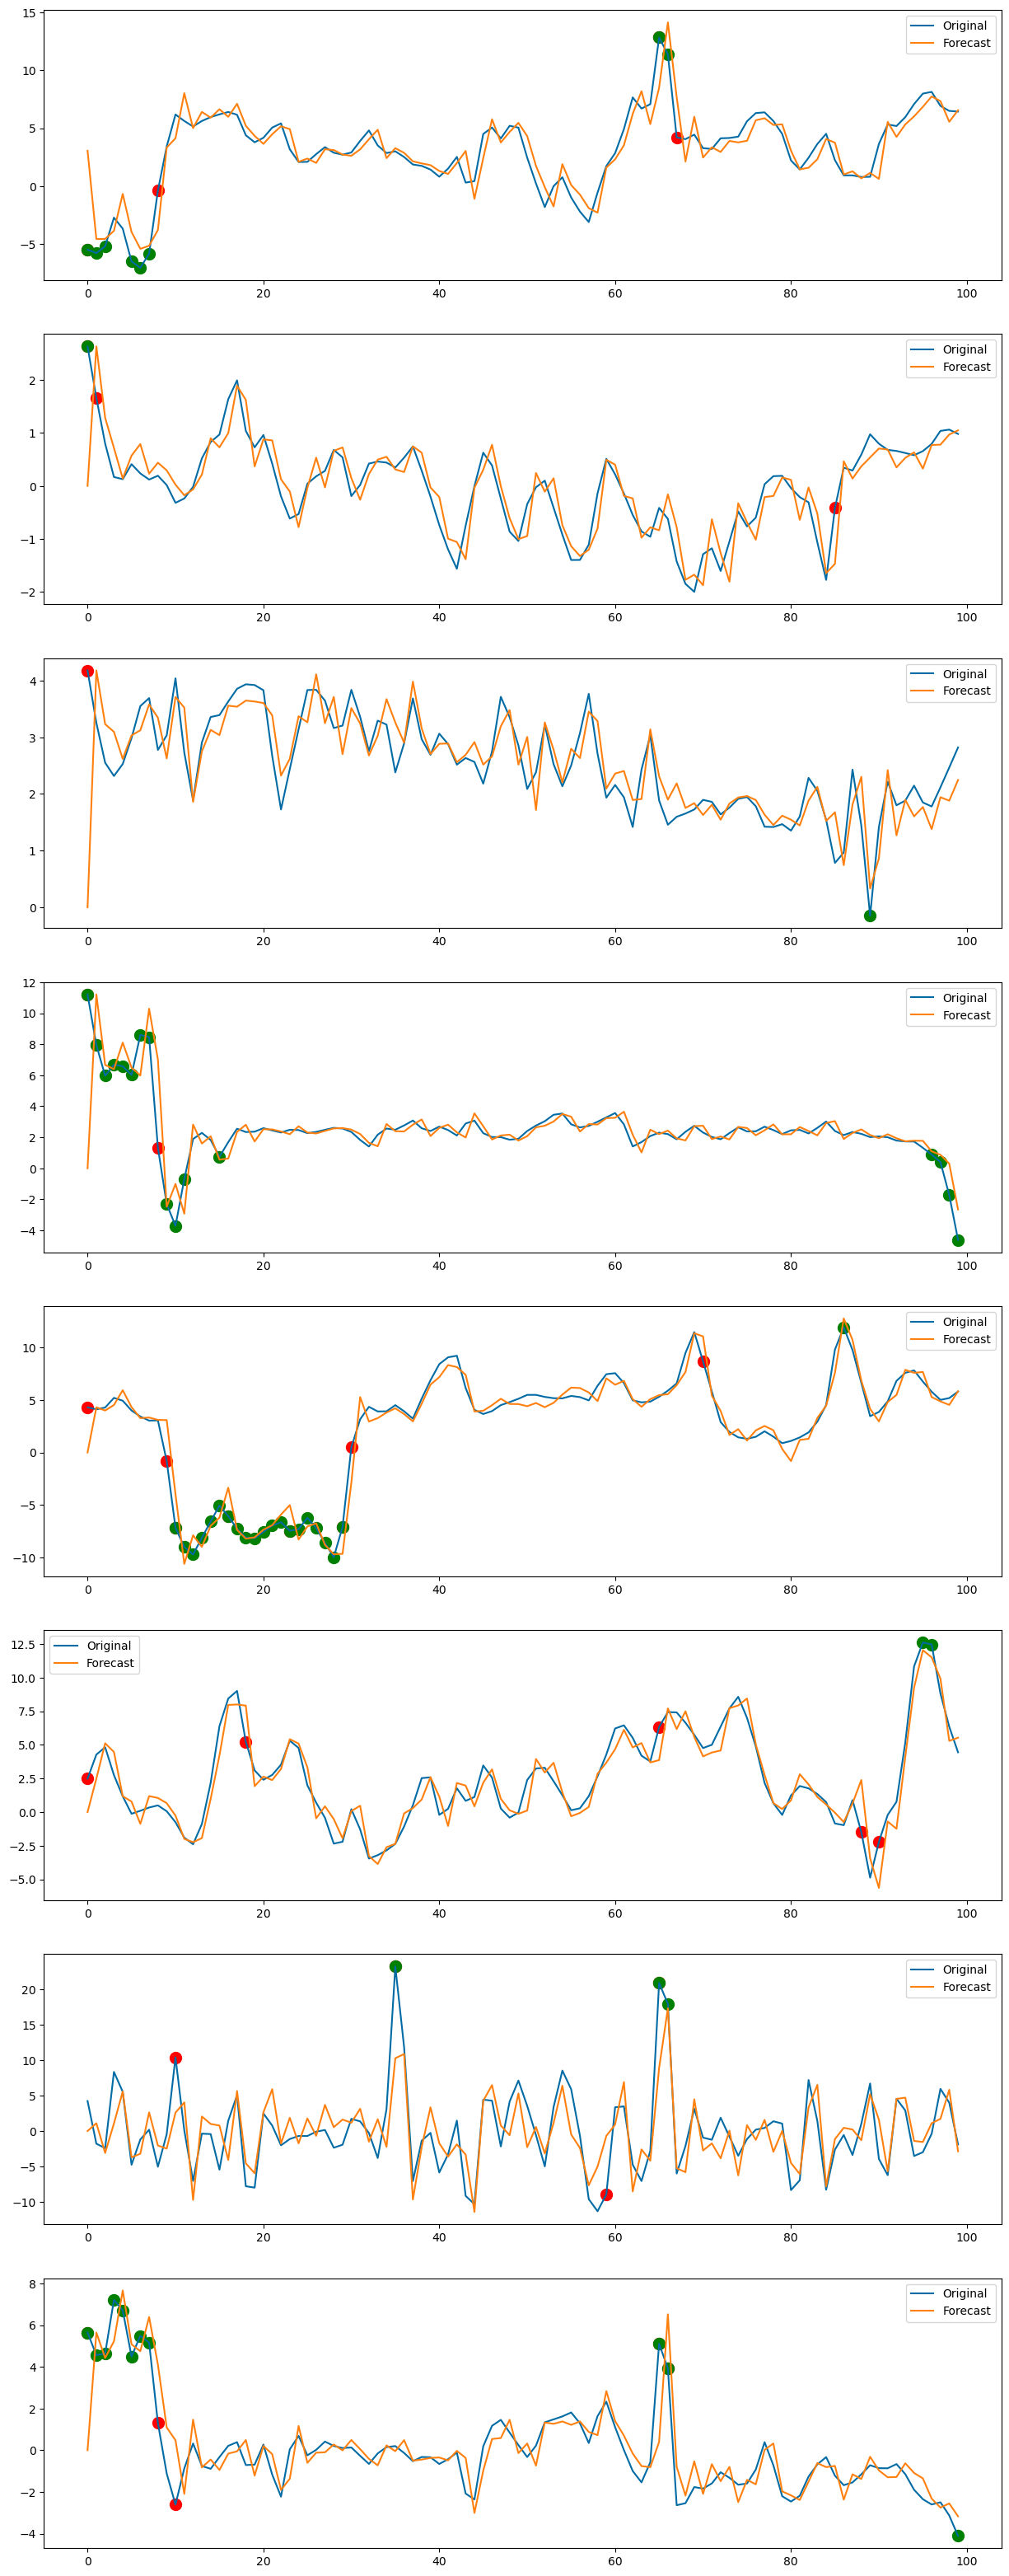

In [12]:
# ARIMA(Autoregressive Integrated Moving Average model)差分整合移动平均自回归模型
# 模型的参数(p, d, q), 每一个元组对应一个地区的模型参数(参数的设置由ADF检验得来)
# p: 时间序列数据本身的滞后数(属于Autoregressive model自回归模型)
# d: 数据进行差分的次数
# q: 预测误差的滞后数(属于Moving average model滑动平均模型)
param = [(4, 0, 5), (4, 1, 3), (11, 1, 6), (3, 1, 2), (7, 1, 17), (4, 1, 8), (3, 0, 6), (4, 1, 5)]
data = pd.read_excel('数据文件.xls')
fig = plt.figure(figsize=(15, 40))

for i in range(1, 9):
    ts = data.iloc[:, i]

    # 进行自动 ARIMA 模型拟合(想看算法拟合的参数可以把下面三行的#去掉)
    # model = auto_arima(ts, seasonal=True, m=12)
    # order = model.order
    # print(order)

    # 训练 ARIMA 模型
    model = ARIMA(ts, order=param[i - 1])
    result = model.fit()

    # 预测
    forecast = result.predict(start=0, end=len(ts)-1, typ='levels')

    ax = fig.add_subplot(8, 1, i)
    ax.plot(ts, label='Original')
    ax.plot(forecast, label='Forecast')

    # 基于2σ准则判断异常点
    # 假设模型的预测值和真实值的差，即残差服从高斯分布
    diff = np.array(ts - forecast)
    diff_std = diff.std()
    diff_mean = diff.mean()

    # 不在（μ - 2σ，μ + 2σ）区间内的布尔索引，即异常值的布尔索引
    outliers = (diff_mean + 2 * diff_std < diff) + (diff < diff_mean - 2 * diff_std)

    # ARIMA模型标注的异常点为红色
    # 箱线图标注的异常点为绿色，有可能把同一个位置的红色点覆盖掉
    ax.scatter(np.arange(100)[outliers], ts[outliers], c='red', s=100)

    # 箱线图
    q1, q3 = ts.quantile(q=[0.25, 0.75])
    iqr = q3 - q1
    outliers_mask = (ts < (q1 - 1.5 * iqr)) | (ts > (q3 + 1.5 * iqr))
    ax.scatter(np.arange(100)[outliers_mask], ts[outliers_mask], c='green', s=100)
    ax.legend()

    # AIC和BIC指标是评估ARIMA模型的，越小越好
    # print('-'*25 + 'region' + str(i) + '-'*25)
    # # 计算模型的AIC和BIC指标
    # print('AIC:', result.aic)
    # print('BIC:', result.bic)
    # print()